# Single Cell Sequencing
## Campari vs Control


Uses exon data extracted from: zUMIs_output\expression\*.dgecounts.rds and gene data from: zUMIs_output\expression\*.gene_names.txt<br>

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import anndata as ad
import hdf5plugin
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os 
#external modules
#pretty plotting
import seaborn as sb
import sys 
sb.set_context(context='poster')

import copy

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

c:\Users\ilosz01\.conda\envs\scs\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\ilosz01\.conda\envs\scs\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\ilosz01\.conda\envs\scs\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarni

scanpy==1.9.3 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.10.6 louvain==0.8.1 pynndescent==0.5.10


c:\Users\ilosz01\.conda\envs\scs\lib\site-packages\umap\umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


## SECTION I: Data loading
Loading adata information that has been agregated and quality controled

In [3]:
figure_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\figuresR'
input_path = r'C:\Users\ilosz01\OneDrive - Linköpings universitet\MarcinLab\SingleCellSequencing\scs_analysis\out'


adata_umap_path = os.path.join(input_path,'control_scs_umap_from_R.h5ad')
adata_path = os.path.join(input_path,'campari_scs_from_R.h5ad')


NO_PCA = 20


In [5]:
adata = ad.read_h5ad(adata_path)
adata_umap = ad.read_h5ad(adata_umap_path)

c:\Users\ilosz01\.conda\envs\scs\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\ilosz01\.conda\envs\scs\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Here we define the stimuli that were used (this assignation of number and id is the one that is used in the plate information excel sheet): 


* 0: control
* 1: pinch
* 2: new_stroke (after december)
* 3: ballon
* 4: AG (ano-genital brush)
* 5: AD (anal distension)
* 6: heating
* 7: mock
* 8: old_stoke (first experiments with stroke)
* 9: anal pinch
* 10: mock with poop
* 11: tomatoe
* 12: poop

In [6]:
adata

AnnData object with n_obs × n_vars = 989 × 25990
    obs: 'barcode', 'stimulus', 'red', 'green', 'well_id', 'batch', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

In [7]:
stim = np.zeros((adata.X.shape[0],))
for i in range(adata.X.shape[0]):
    stim[i] = adata.obs['stimulus'][i]

Number of campari cells =  521
Number of control cells =  468
computing PCA
    on highly variable genes
    with n_comps=20
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=20


c:\Users\ilosz01\.conda\envs\scs\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


    finished (0:00:00)


c:\Users\ilosz01\.conda\envs\scs\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


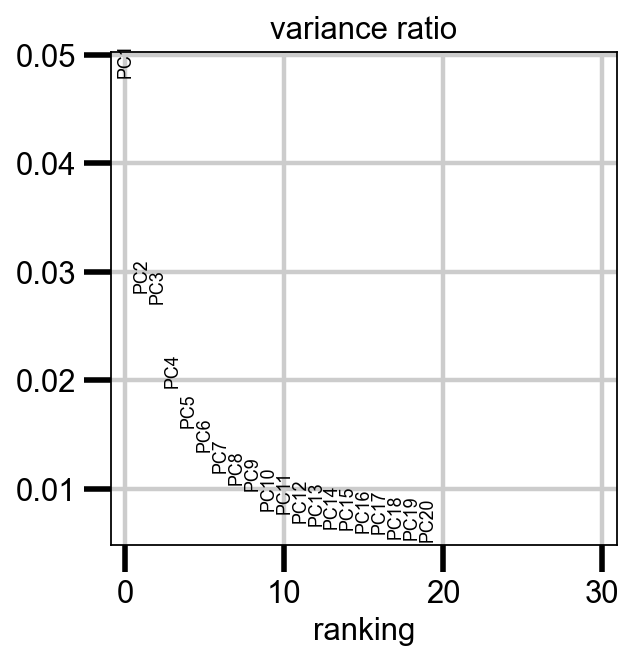

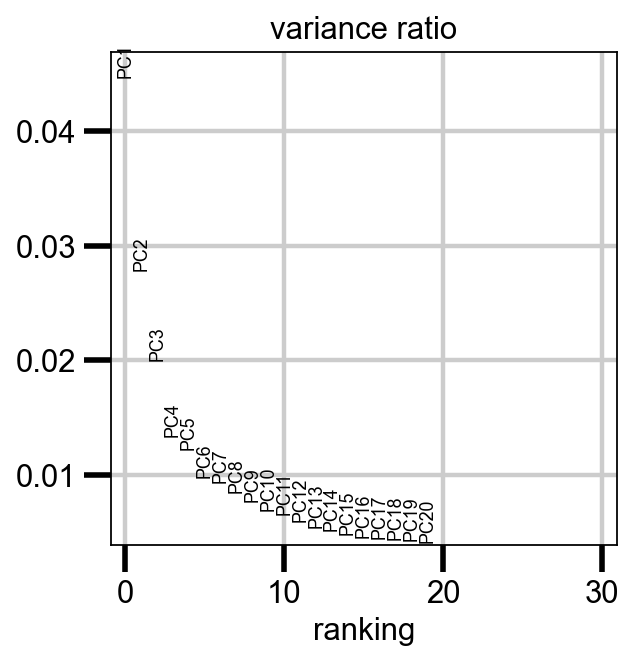

In [8]:
campari_cells = np.where(stim != 0)[0]
control_cells = np.where(stim == 0)[0]

print('Number of campari cells = ', len(campari_cells))
print('Number of control cells = ', len(control_cells))

adata_campari = adata[campari_cells,:]
adata_control = adata[control_cells,:]

### Dimentionality reduction examples using multiple techniques
### Select one number of componets, for example n = 15 and do louvain in the umap transformation 
# with that number of componets (we use the same number of components that was previously selected)
N_selected = NO_PCA
sc.pp.pca(adata_campari, n_comps=N_selected, use_highly_variable=True, svd_solver='arpack')
sc.pp.pca(adata_control, n_comps=N_selected, use_highly_variable=True, svd_solver='arpack')

rcParams['figure.figsize']=(4,4)
sc.pl.pca_variance_ratio(adata_campari)
sc.pl.pca_variance_ratio(adata_control)

In [9]:
sc.pp.neighbors(adata_campari)
sc.tl.tsne(adata_campari)
sc.tl.umap(adata_campari)

sc.pp.neighbors(adata_control)
sc.tl.tsne(adata_control)
sc.tl.umap(adata_control)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing tSNE
    using 'X_pca' with n_pcs = 20
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 20
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


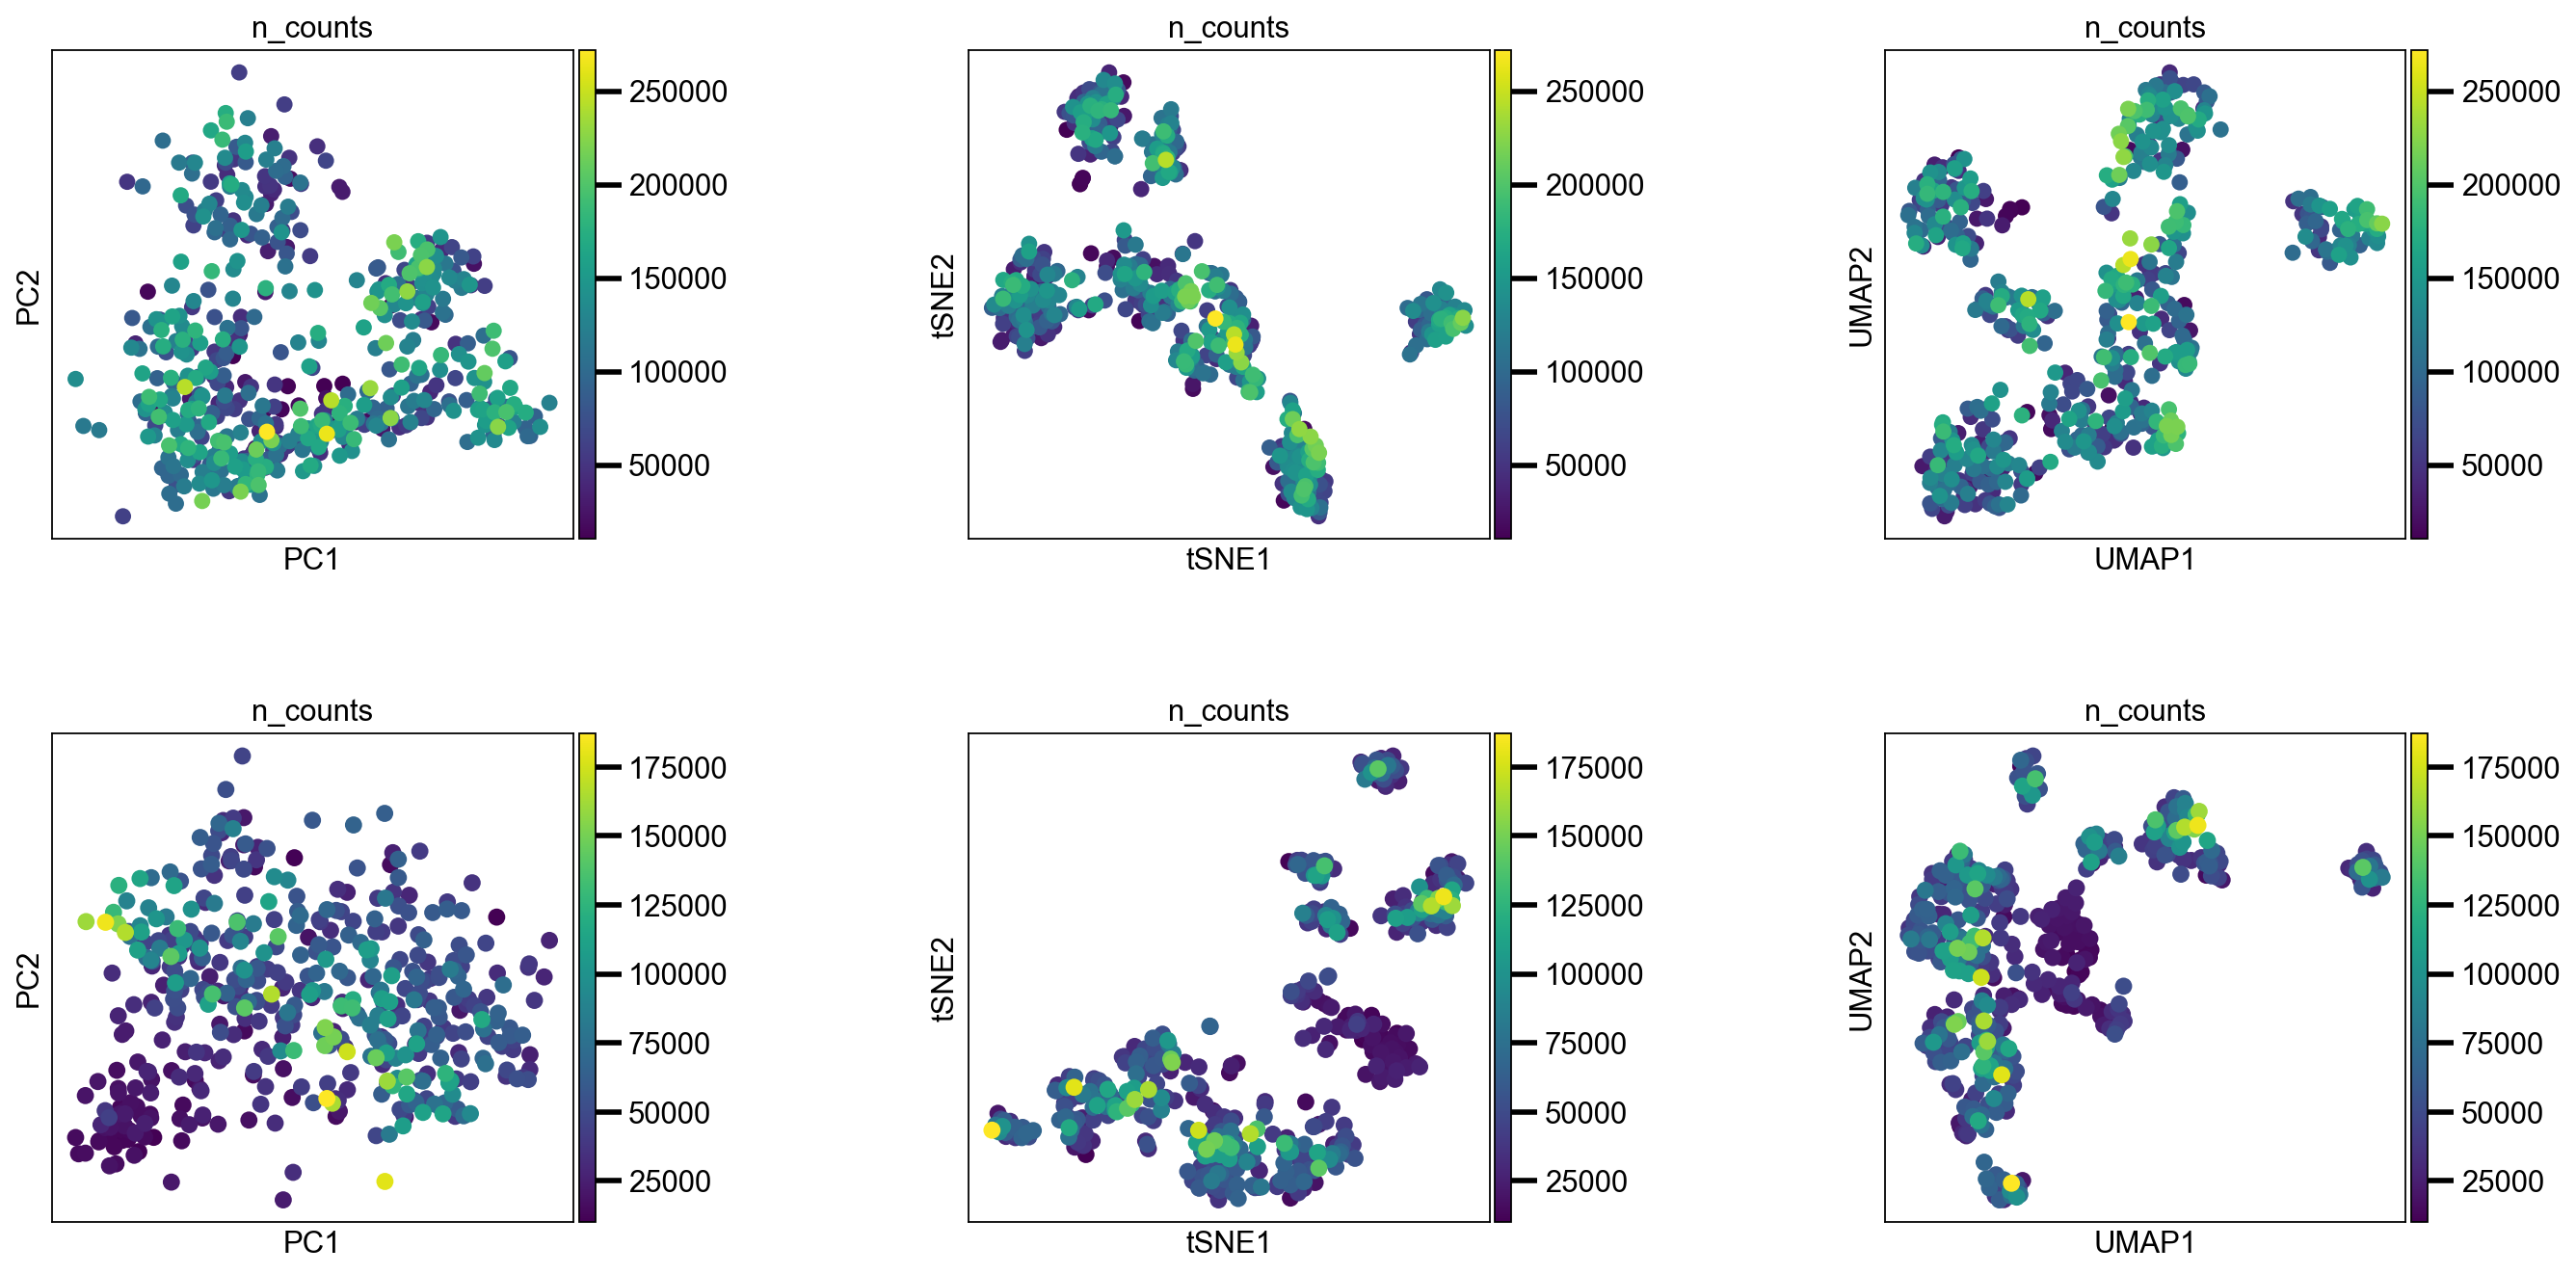

In [10]:
rcParams['figure.figsize']=(20,10)
fig_ind=np.arange(231, 237)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p10 = sc.pl.pca_scatter(adata_campari, color='n_counts', ax=fig.add_subplot(fig_ind[0]), show=False)
p11 = sc.pl.tsne(adata_campari, color='n_counts', ax=fig.add_subplot(fig_ind[1]), show=False)
p12 = sc.pl.umap(adata_campari, color='n_counts', ax=fig.add_subplot(fig_ind[2]), show=False)
p20 = sc.pl.pca_scatter(adata_control, color='n_counts', ax=fig.add_subplot(fig_ind[3]), show=False)
p21 = sc.pl.tsne(adata_control, color='n_counts', ax=fig.add_subplot(fig_ind[4]), show=False)
p22 = sc.pl.umap(adata_control, color='n_counts', ax=fig.add_subplot(fig_ind[5]), show=False)

plt.show()

In [11]:
rcParams['figure.figsize']=(4,4)

labels=['Control','pinch','new_stroke','ballon','AG','AD','heating','mock','old_stroke','anal_pinch','mock_w_poop','vaginal_distension','tomatoe','poop']
color = ['gainsboro','green','darkorange','purple','magenta','cyan','red','orange','yellow','brown','orange','blue','violet','k']


### transform adata sparse matrix to scipy
x = adata_umap.X
### create exportable arrays with information about stimuli, fluorecence, and louvain transformations
stim = np.zeros((x.shape[0],))
red = np.zeros((x.shape[0],))
green = np.zeros((x.shape[0],))
for i in range(x.shape[0]):
    stim[i] = adata_umap.obs['stimulus'][i]
    red[i] = adata_umap.obs['red'][i]
    green[i] = adata_umap.obs['green'][i]


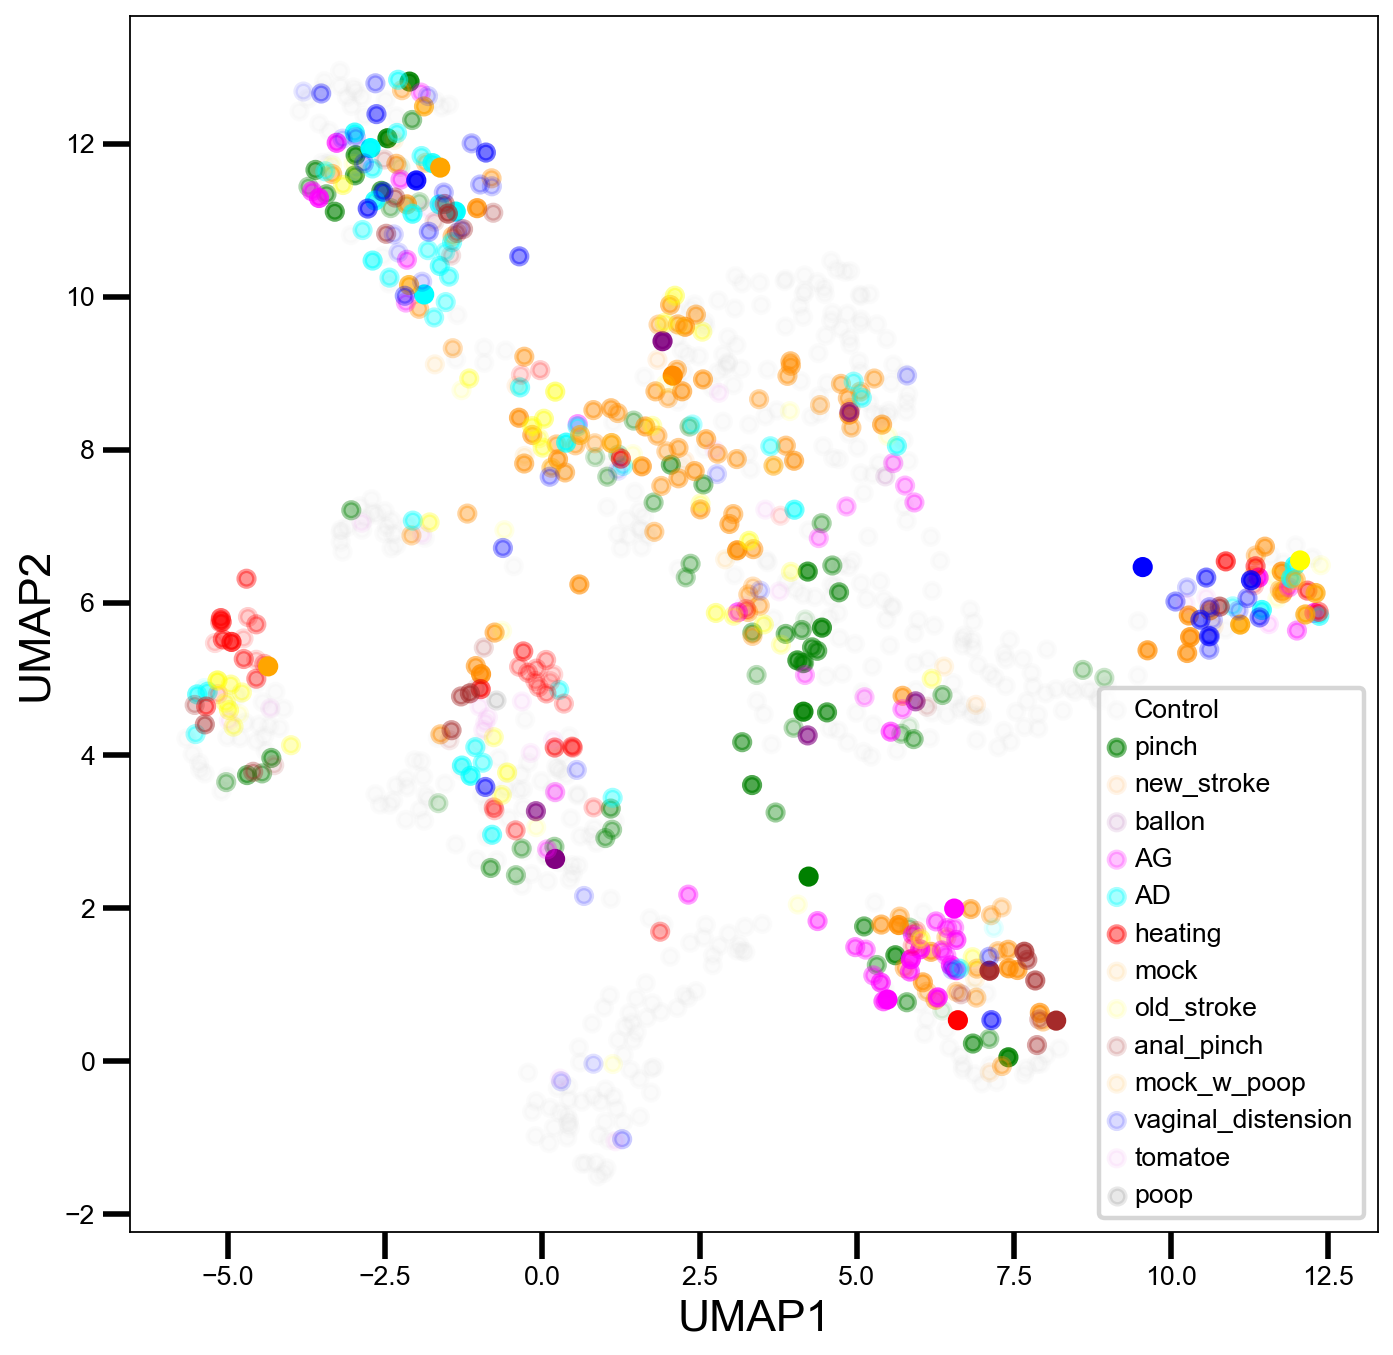

In [12]:
### plotting all stimulus together

figure, axes = plt.subplots()
#red_norm = (red - np.min(red)) / (np.max(red) - np.min(red))
for i in range(len(labels)):
    index = np.where(stim == i)[0]
    red_norm = (red[index] - np.min(red[index])) / (np.max(red[index]) - np.min(red[index]) + sys.float_info.epsilon)
    red_norm = (red_norm + 0.1)/1.1
    axes.scatter(adata_umap.obsm['X_umap'][index,0],adata_umap.obsm['X_umap'][index,1], s = 50, c = color[i], alpha = red_norm)
axes.grid(visible = 'None')
#axes.set_xlim([0,19])
#axes.set_ylim([0,19])
axes.set_xlabel('UMAP1', fontsize = 20)
axes.set_ylabel('UMAP2', fontsize = 20)
axes.tick_params(axis='both', which='major', labelsize=12)
axes.tick_params(axis='both', which='minor', labelsize=12)
axes.grid(False)

axes.legend(labels, fontsize = 12)
#sc.pl.umap(adata, color = 'stimulus', color_map = 'Set1', save = 'stimulus'+ '.png', size = 180)
figure.set_size_inches([10,10])
figure.savefig(os.path.join(figure_path, 'stimulus.png'))

(541, 25990)


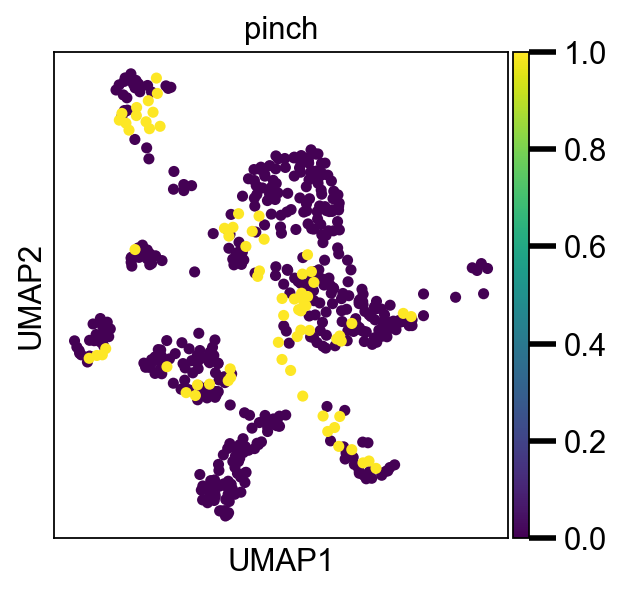

(586, 25990)


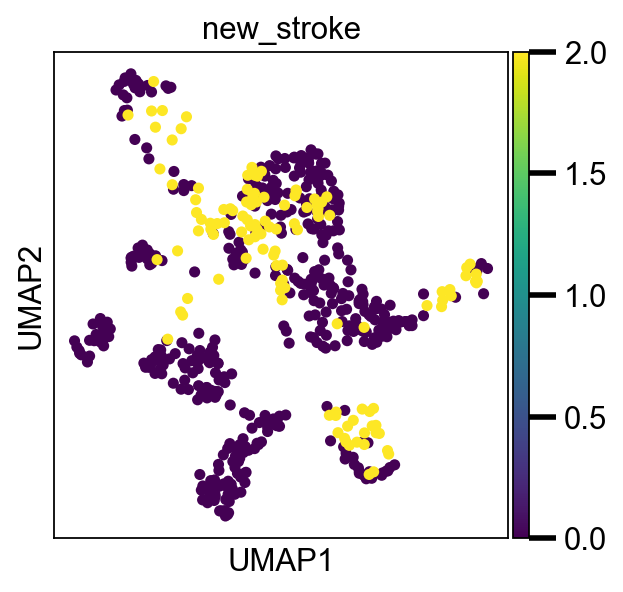

(475, 25990)


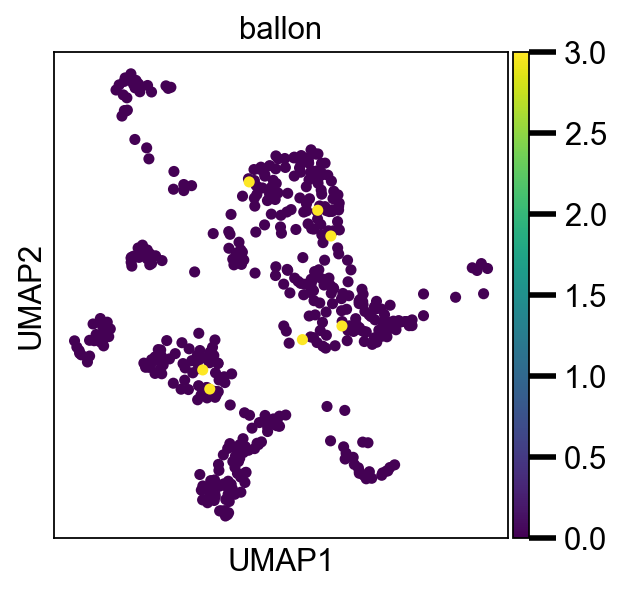

(515, 25990)


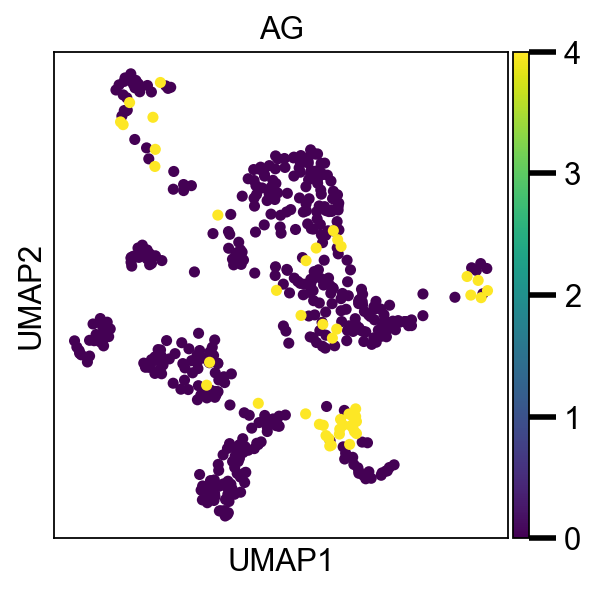

(521, 25990)


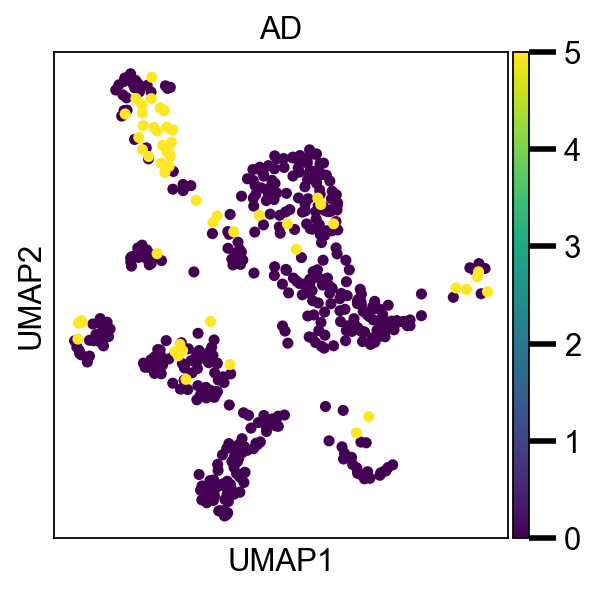

(517, 25990)


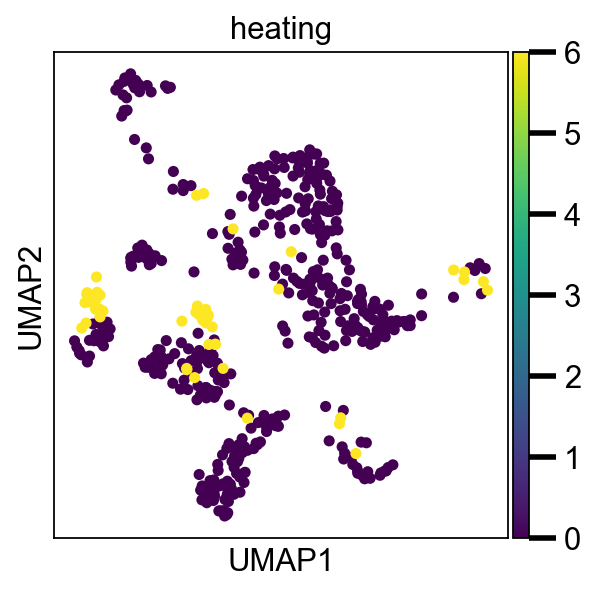

(482, 25990)


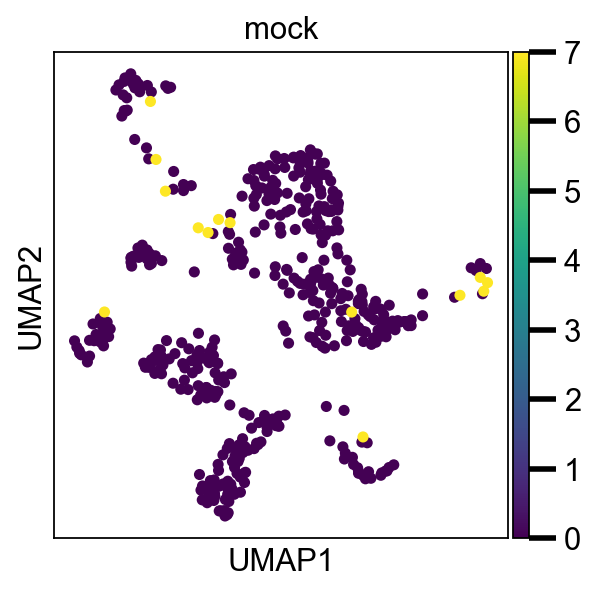

(520, 25990)


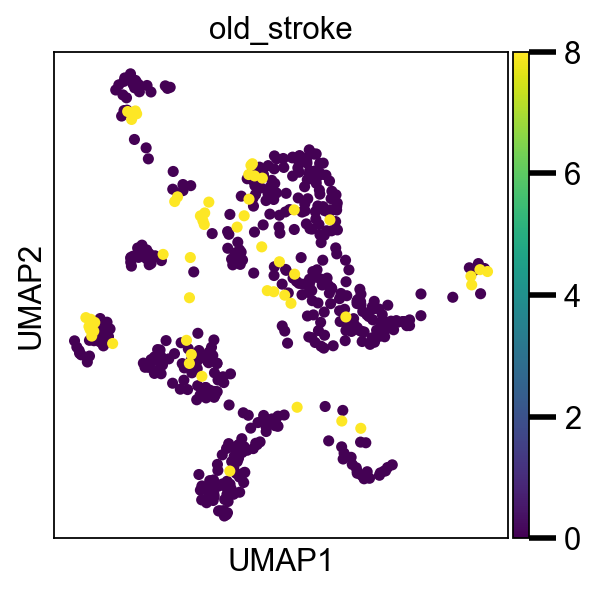

(498, 25990)


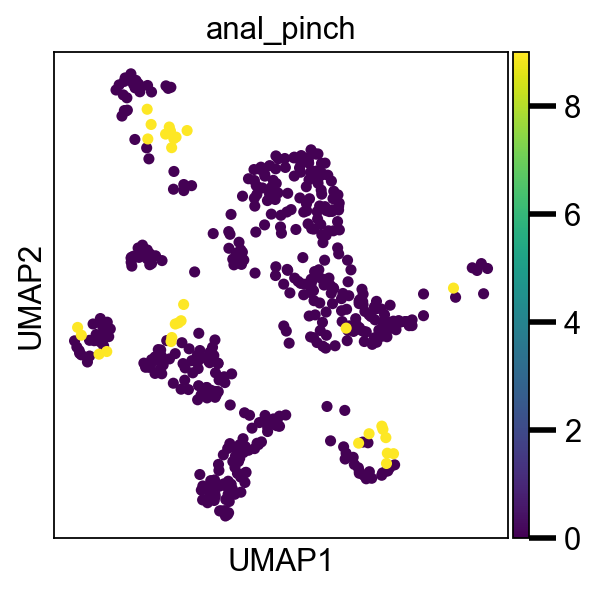

(472, 25990)


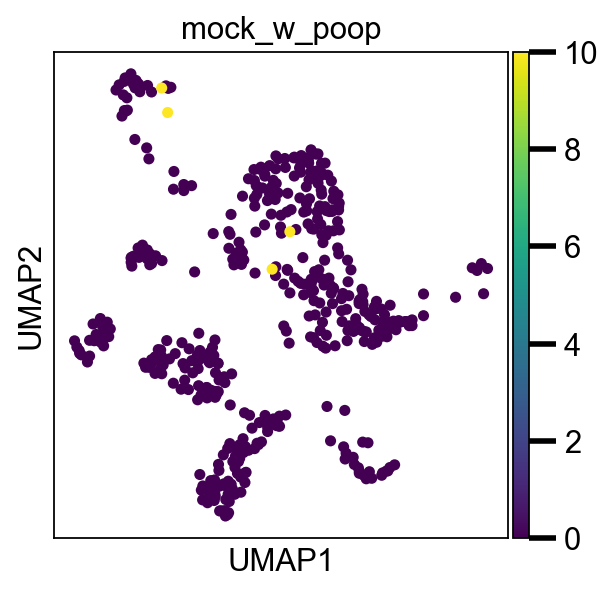

(520, 25990)


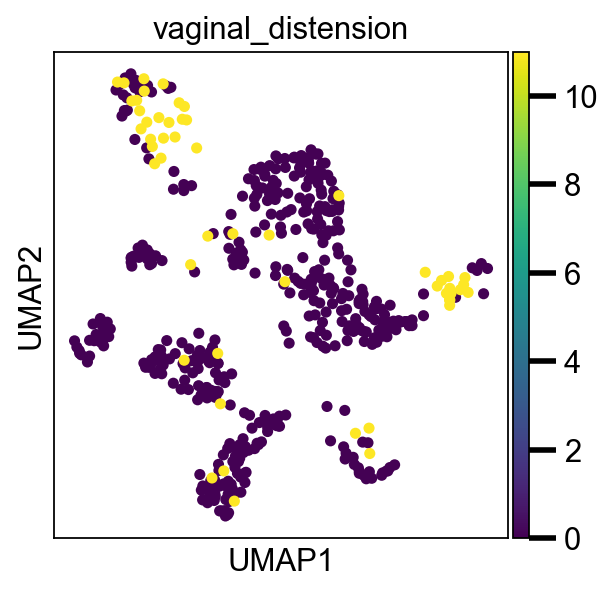

(489, 25990)


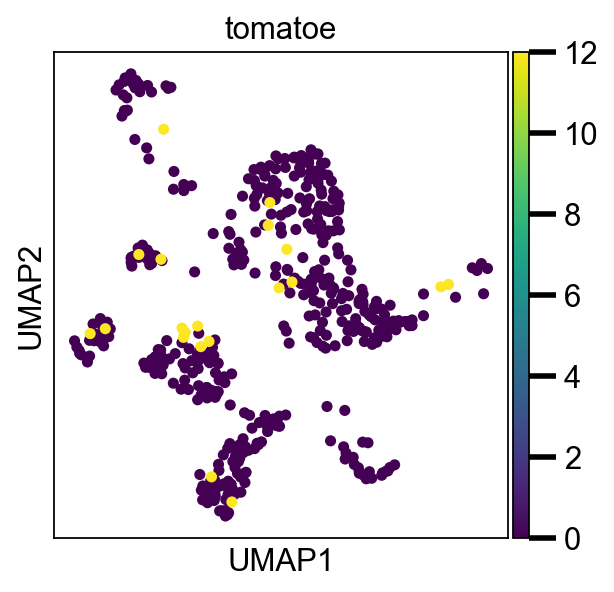

(469, 25990)


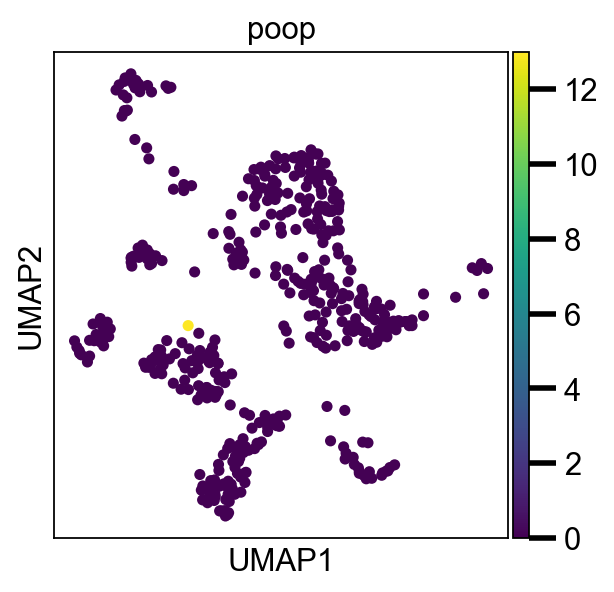

In [13]:
### plotting stimuli individualy

rcParams['figure.figsize']=(4,4)

for i in range(1,len(labels)):
    index = np.logical_or(adata_umap.obs['stimulus'] == i,adata_umap.obs['stimulus'] == 0)
    aux_adata = adata_umap[index,:]
    print(aux_adata.shape)
    sc.pl.umap(aux_adata, color = 'stimulus', title=labels[i], color_map = 'viridis', save = '_stimulus_' + labels[i]+ '.png', size = 100)

0
[]
4
[0]
5
[0, 4]
2
[0, 4, 5]
1
[0, 4, 5, 2]
9
[0, 4, 5, 2, 1]
6
[0, 4, 5, 2, 1, 9]
11
[0, 4, 5, 2, 1, 9, 6]
12
[0, 4, 5, 2, 1, 9, 6, 11]


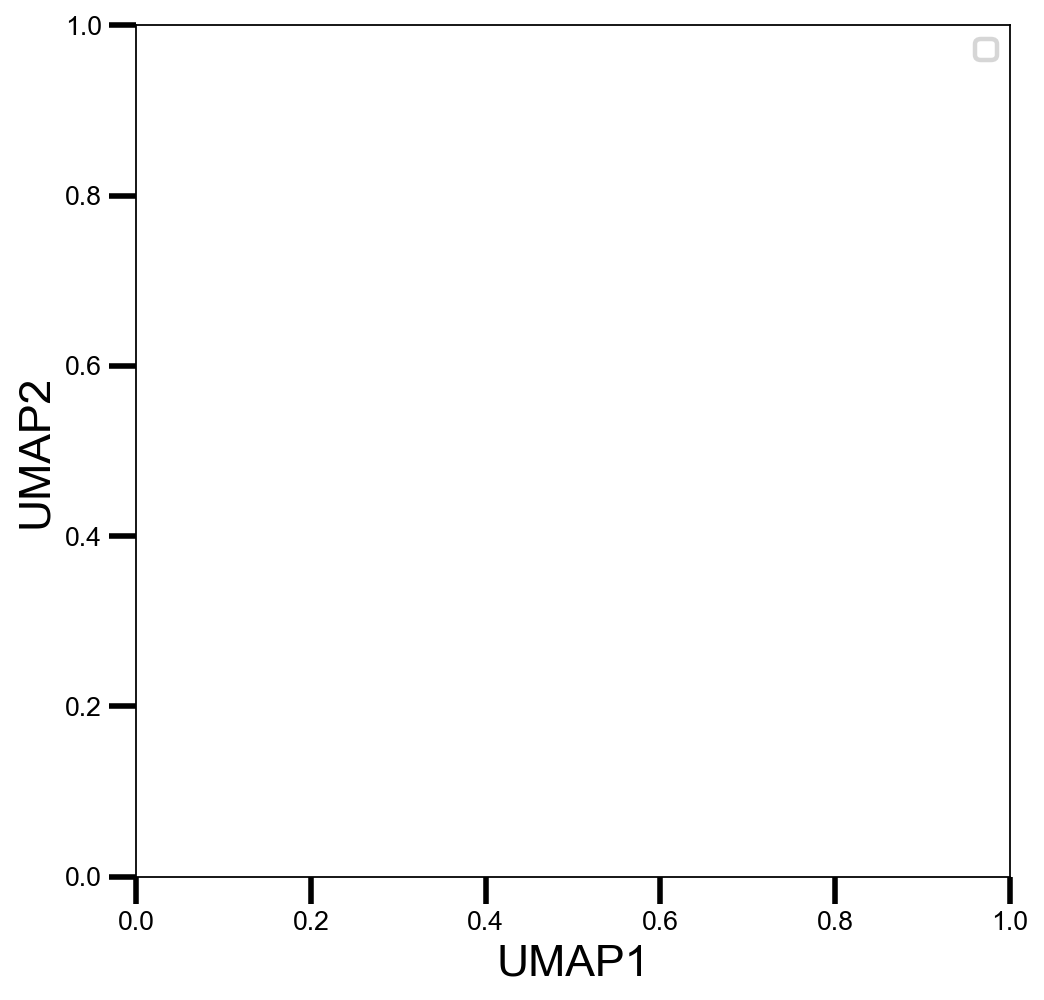

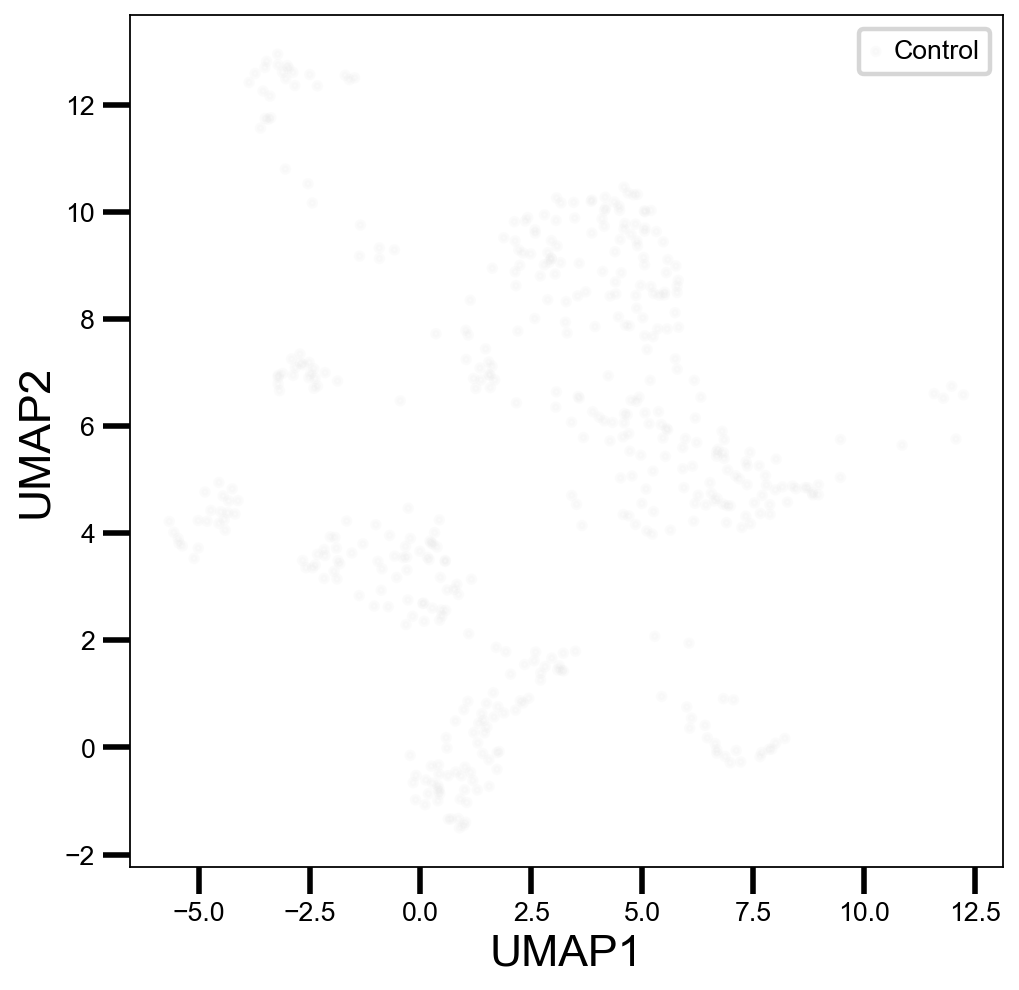

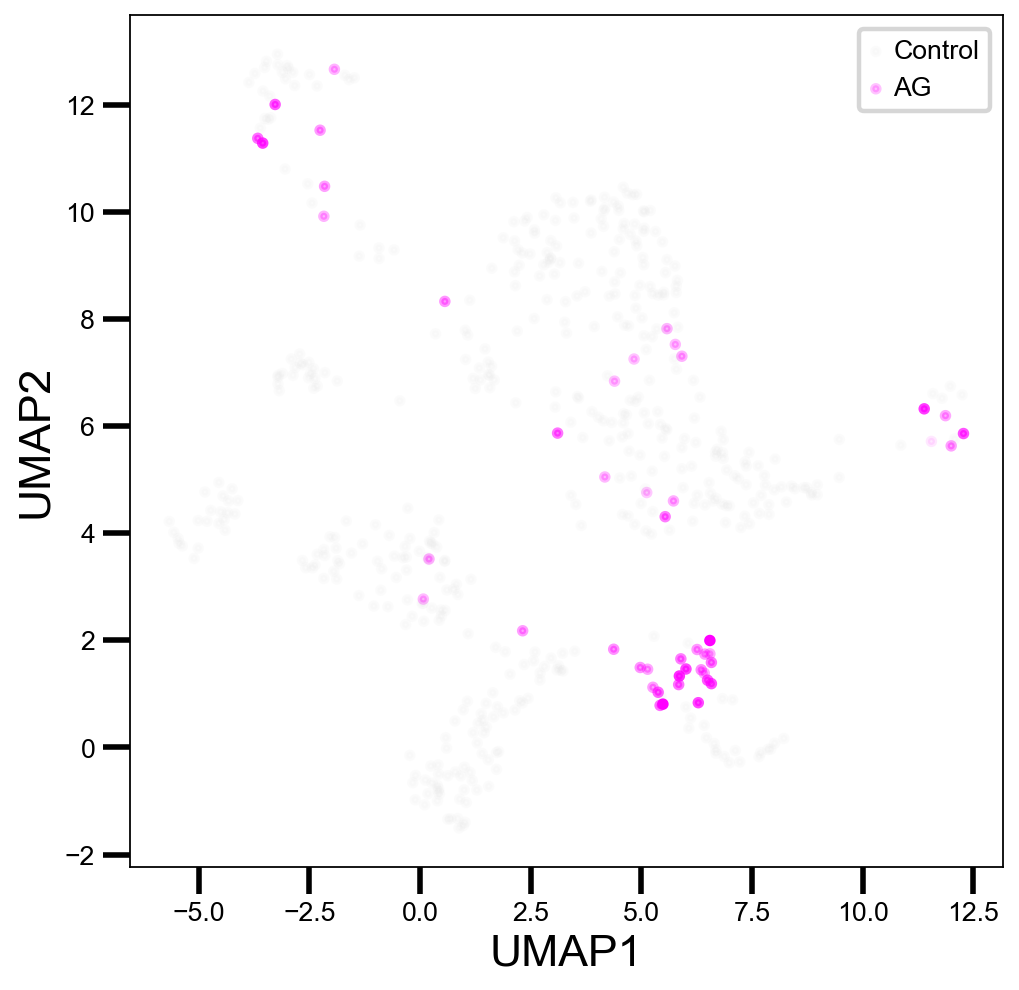

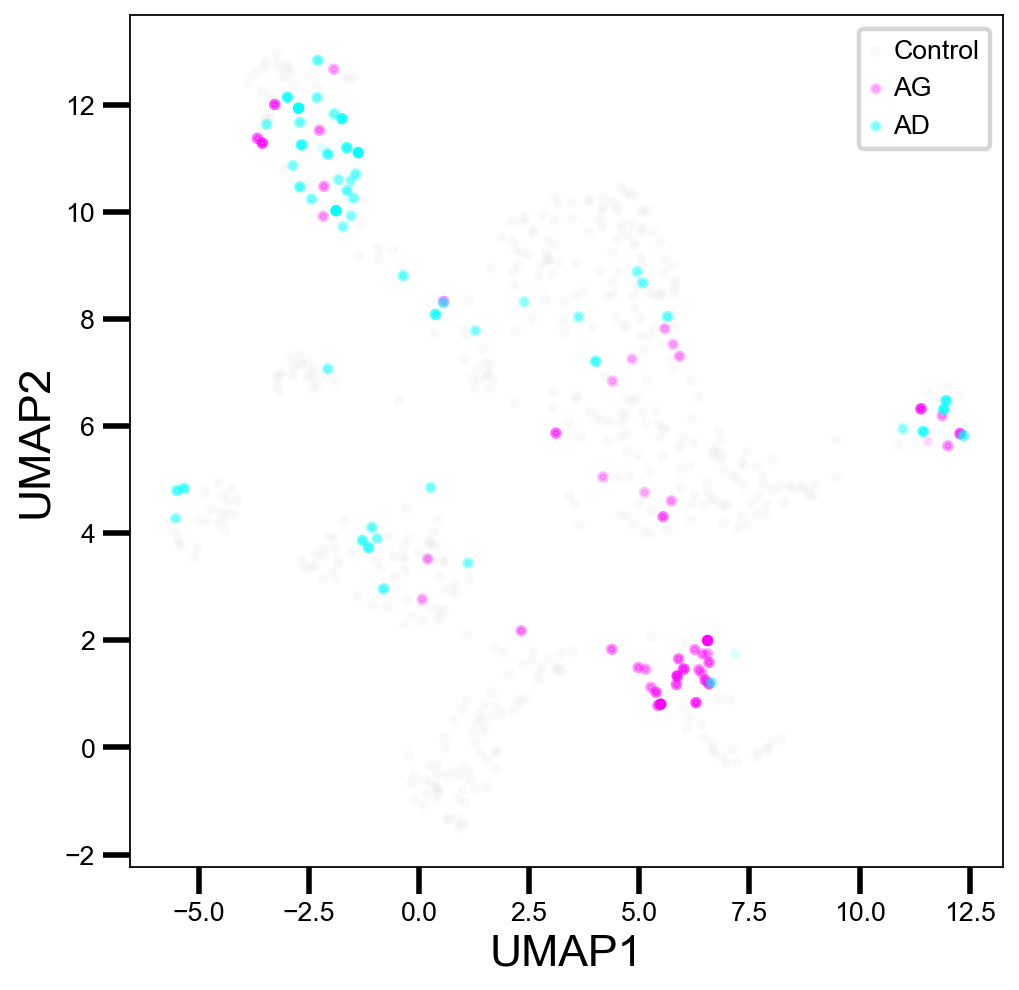

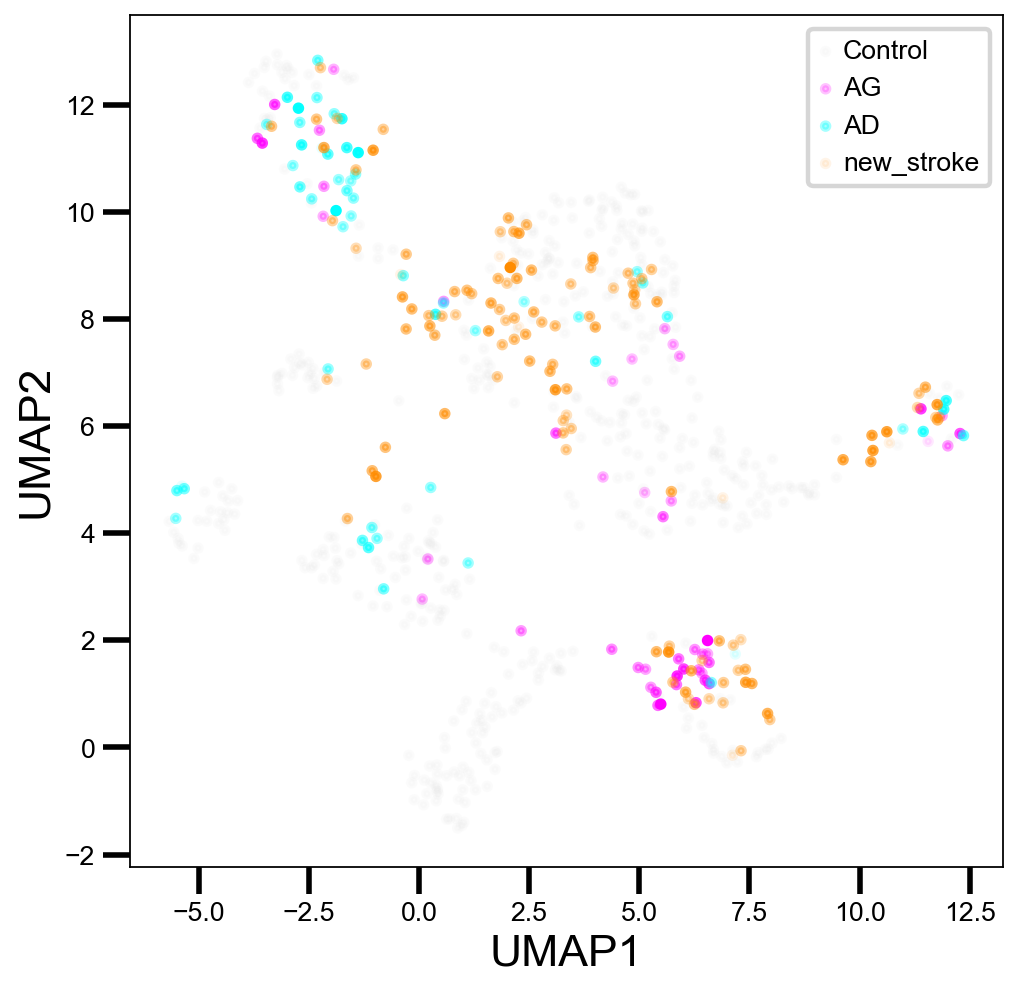

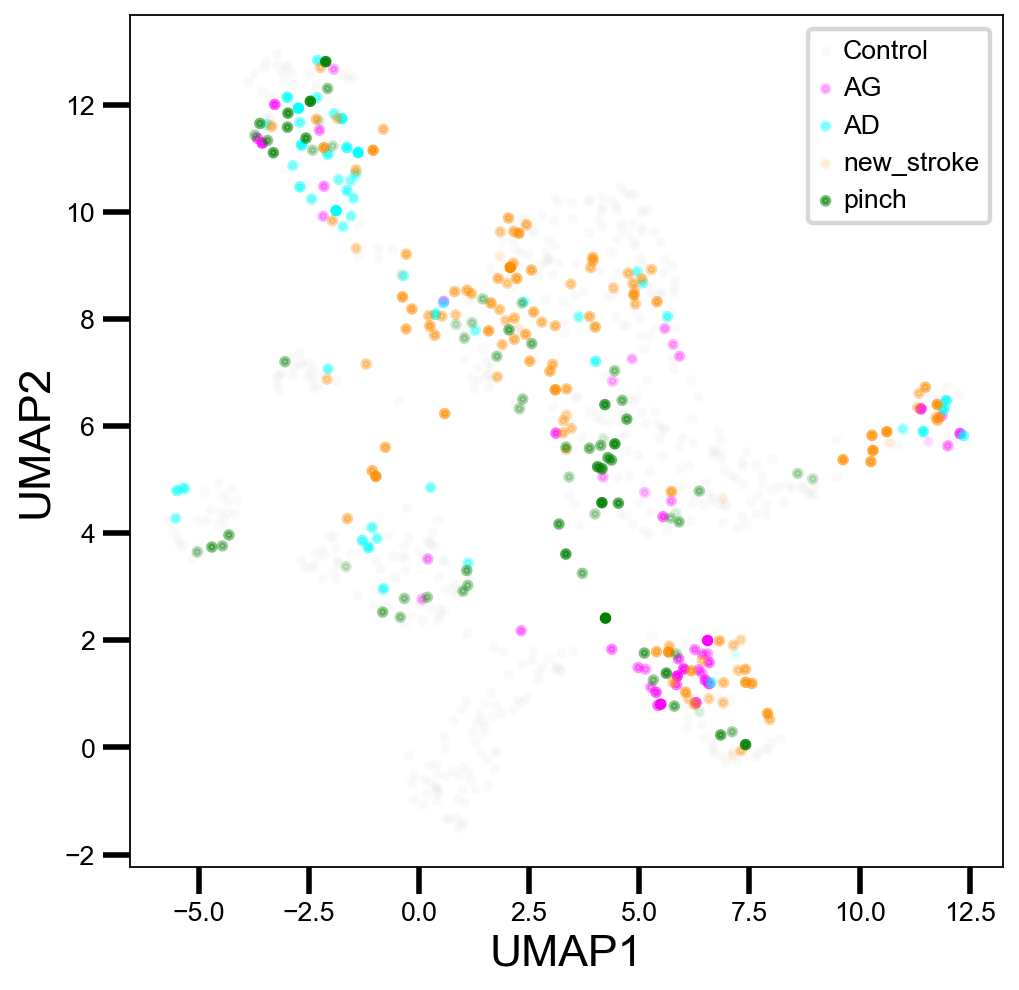

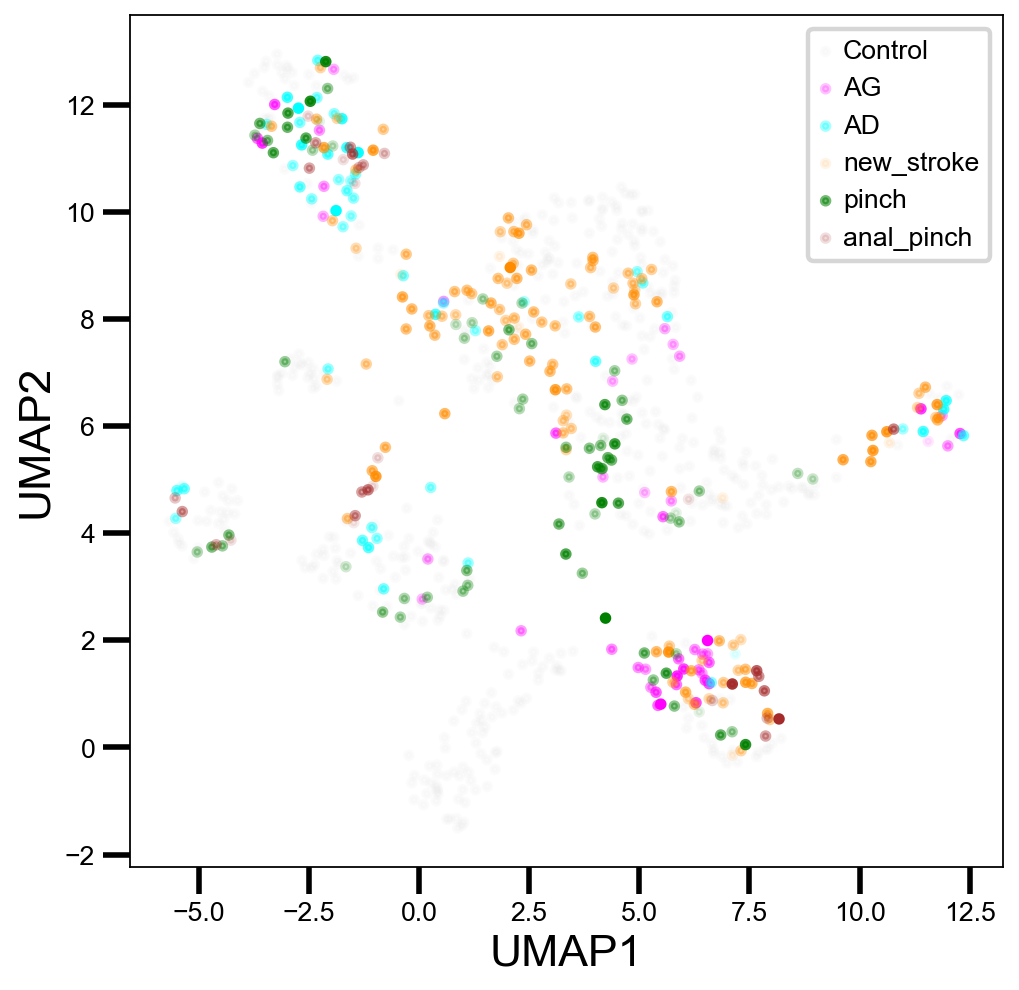

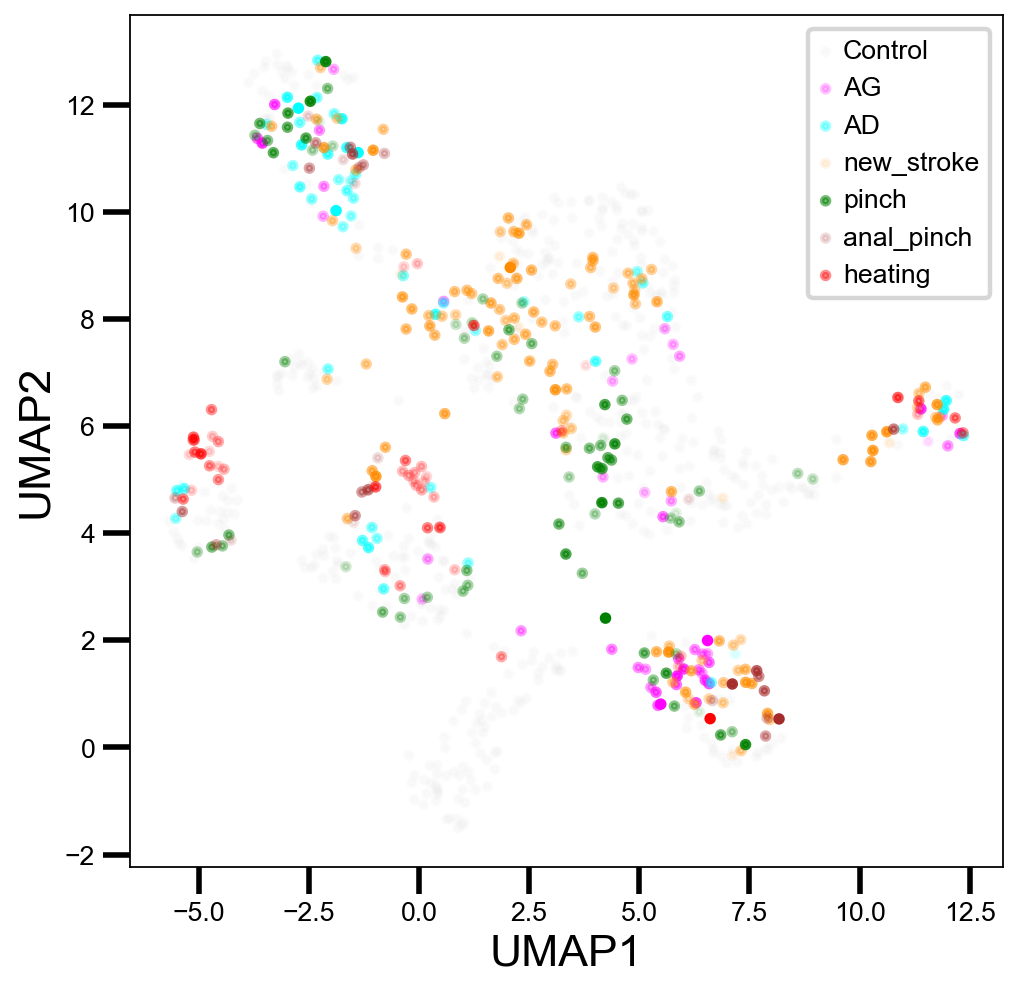

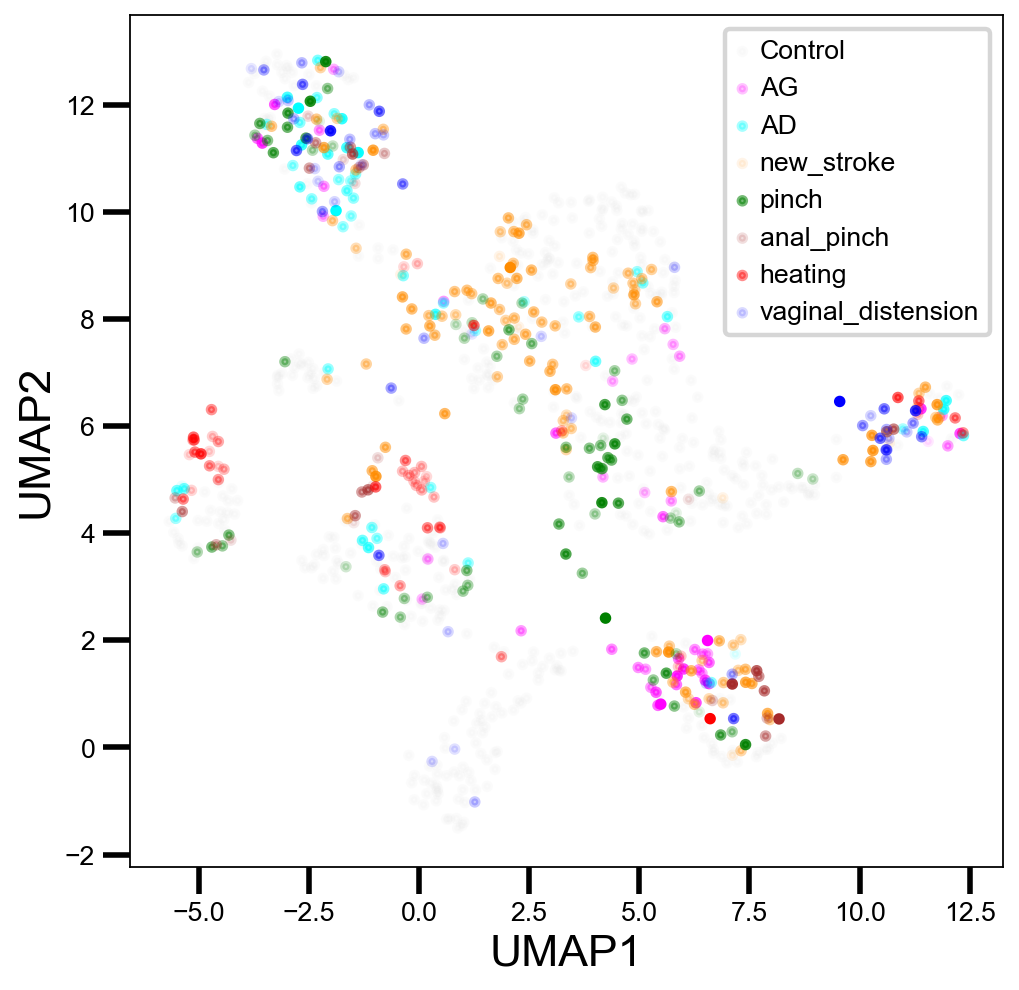

In [14]:
### plotting subsequent stimulus to add individually in a gif (only for selected stimuli)
stimulus_list = [0,4,5,2,1,9,6,11,12]
new_labels=['Control','AG','AD','new_stroke','pinch','anal_pinch','heating','vaginal_distension','non']
count = 0
for i in stimulus_list:
    print(i)
    figure, axes = plt.subplots()
    sublist = stimulus_list[0:count]
    print(sublist)
    for j in sublist:
        index = np.where(stim == j)[0]
        red_norm = (red[index] - np.min(red[index])) / (np.max(red[index]) - np.min(red[index]) + sys.float_info.epsilon)
        red_norm = (red_norm + 0.1)/1.1
        axes.scatter(adata_umap.obsm['X_umap'][index,0],adata_umap.obsm['X_umap'][index,1], s = 10, c = color[j],alpha = red_norm)

    axes.grid(visible = 'None')
    #axes.set_xlim([0,22])
    #axes.set_ylim([0,22])
    axes.set_xlabel('UMAP1', fontsize = 20)
    axes.set_ylabel('UMAP2', fontsize = 20)
    axes.tick_params(axis='both', which='major', labelsize=12)
    axes.tick_params(axis='both', which='minor', labelsize=12)
    axes.grid(False)
    axes.legend(new_labels, fontsize = 12)
    figure.set_size_inches([7,7])
    figure.savefig(os.path.join(figure_path, 'cum_stimulus'+ str(count) +'.png'))

    count = count +1 

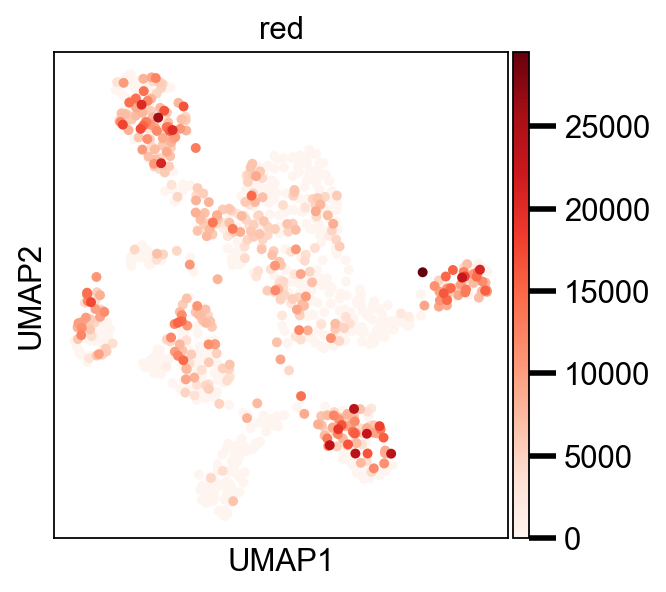

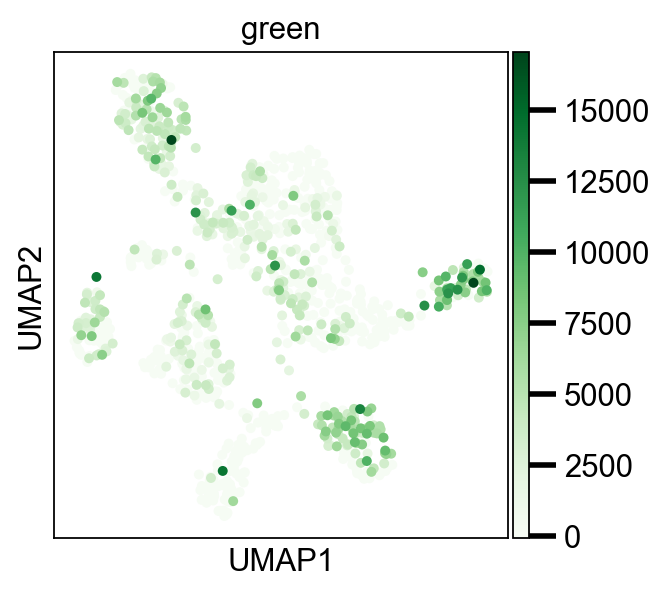

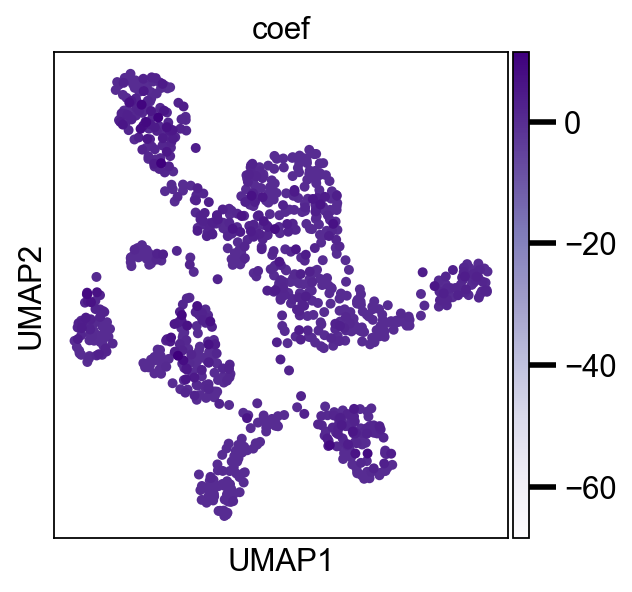

In [15]:
### plotting fluorecence levels 

sc.pl.umap(adata_umap, color='red', color_map = 'Reds', save = '_fluorecence_red_f' + '.png', size = 80)
sc.pl.umap(adata_umap, color='green', color_map = 'Greens', save = '_fluorecence_green_f' + '.png', size = 80)
adata_umap.obs['coef'] = adata_umap.obs['red']/(adata_umap.obs['green'] + sys.float_info.epsilon)
sc.pl.umap(adata_umap, color='coef', color_map = 'Purples', save = '_fluorecence_coef_f' + '.png', size = 80)

(541, 25990)


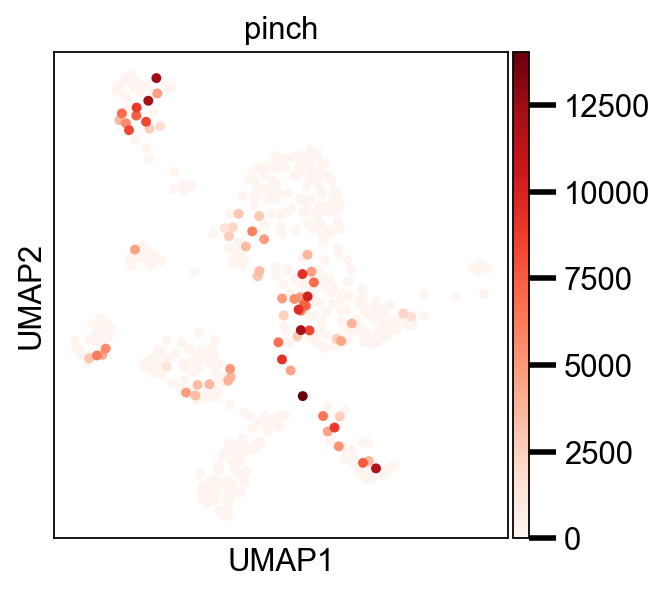

(586, 25990)


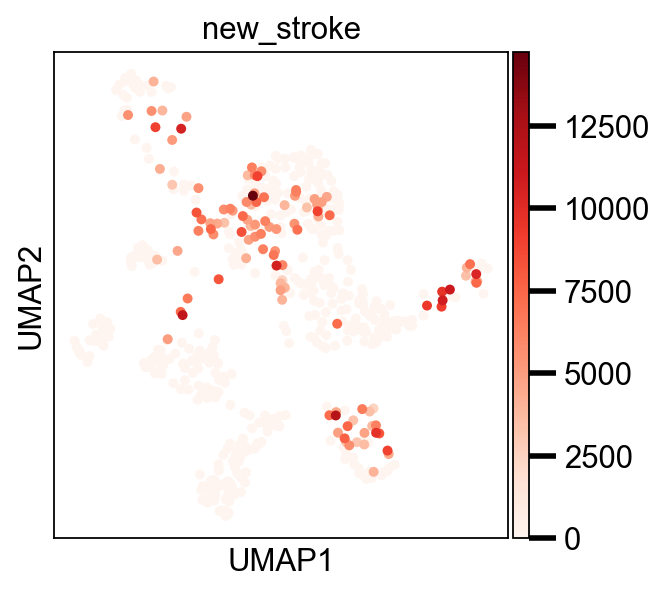

(475, 25990)


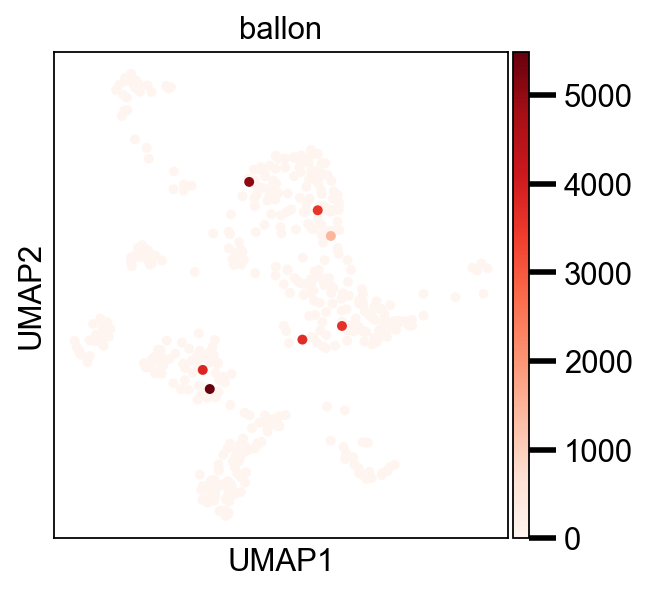

(515, 25990)


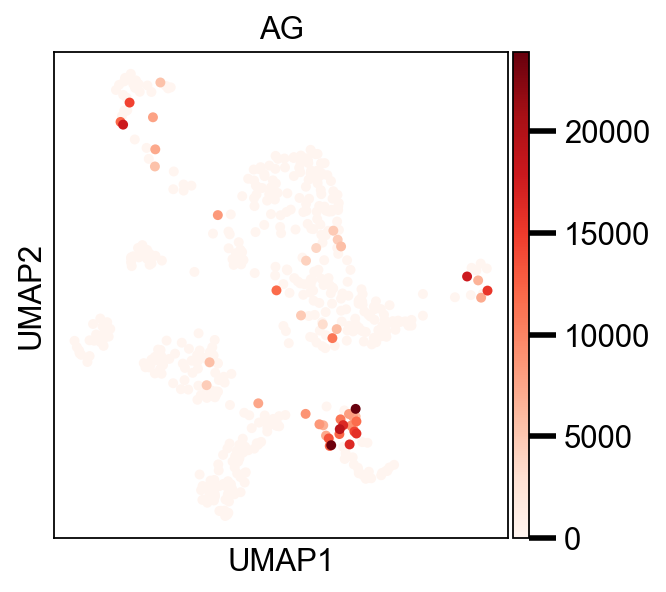

(521, 25990)


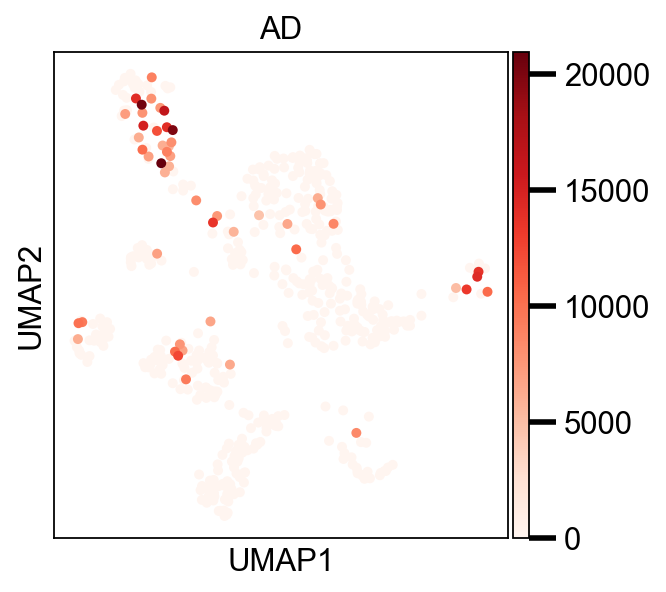

(517, 25990)


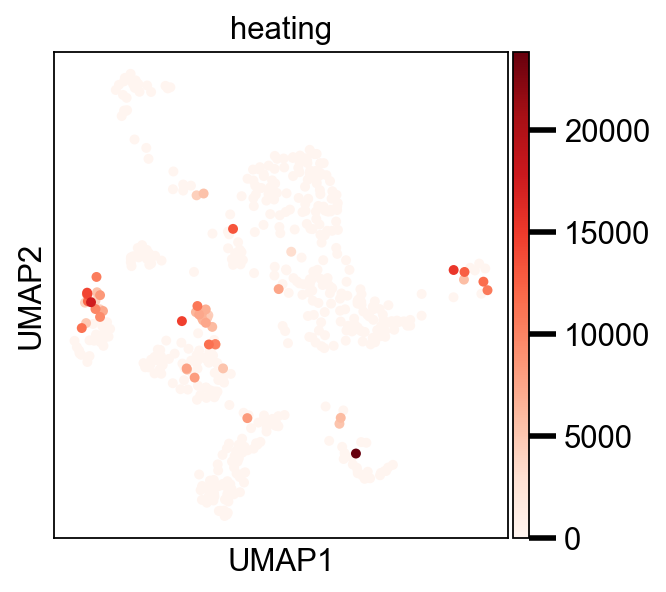

(482, 25990)


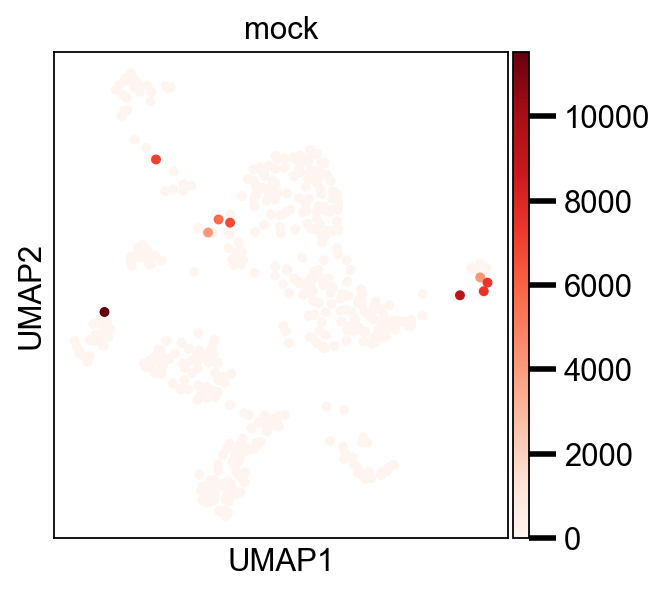

(520, 25990)


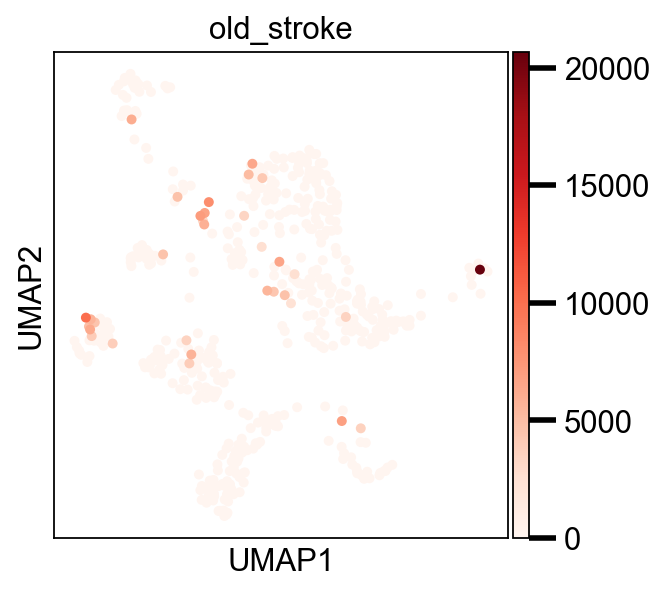

(498, 25990)


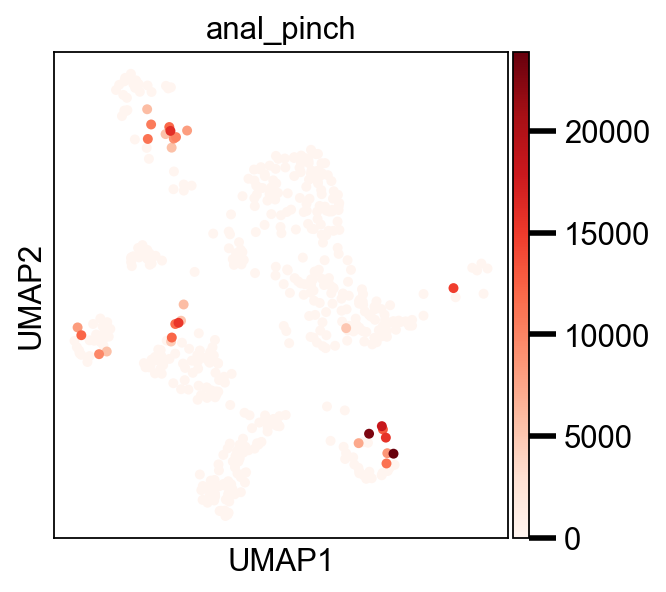

(472, 25990)


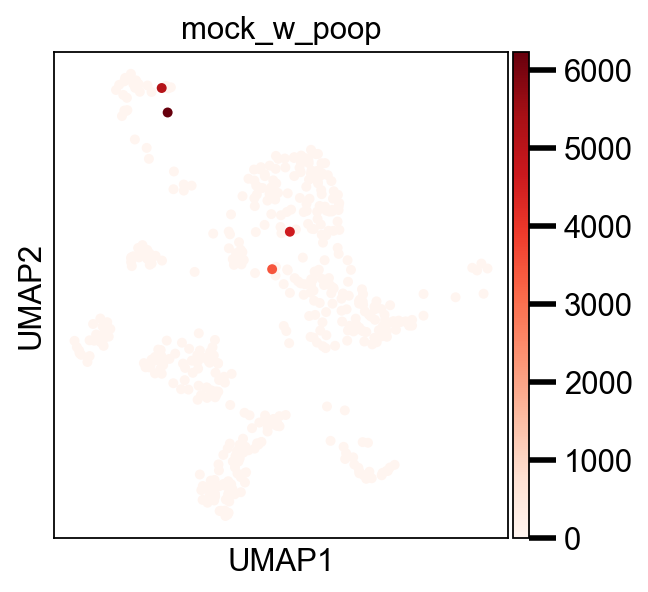

(520, 25990)


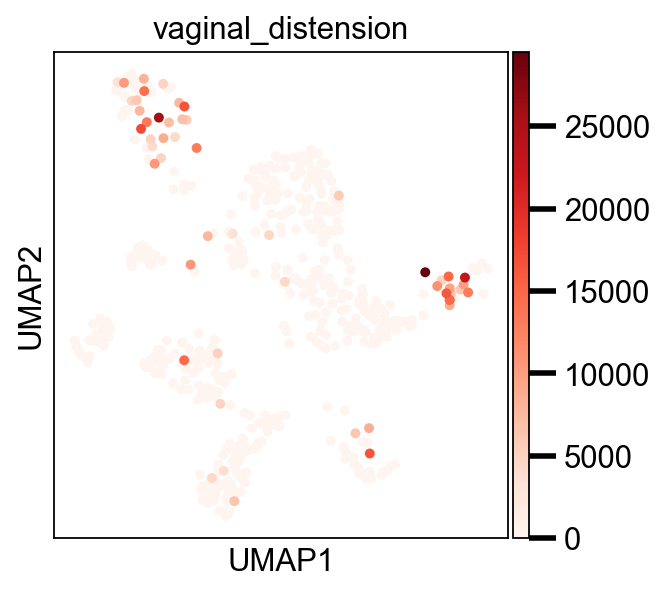

(489, 25990)


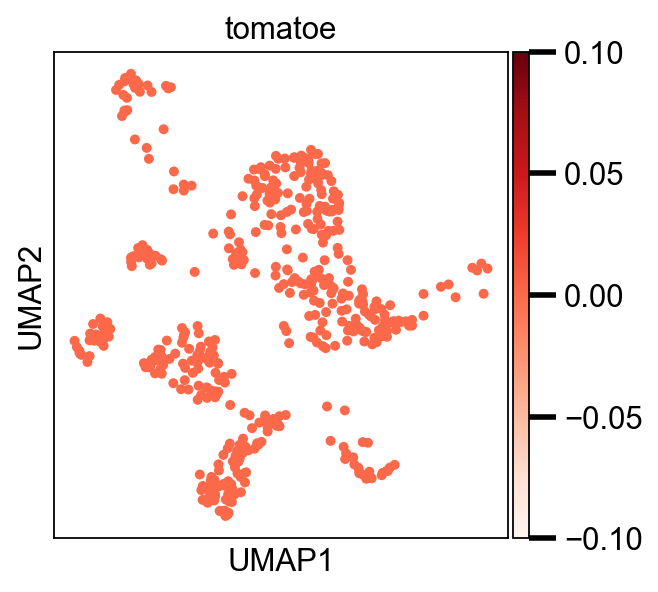

(469, 25990)


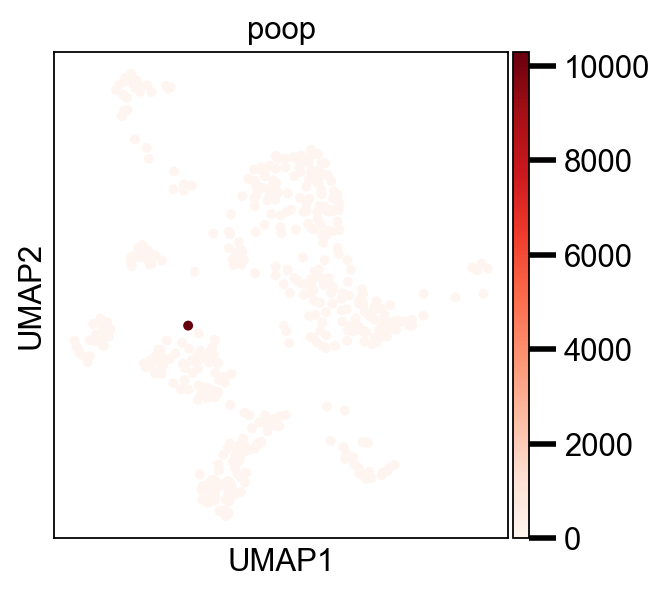

In [16]:
### plotting fluorecence levels stimulus by stimulus
for i in range(1,14):
    index = np.logical_or(adata_umap.obs['stimulus'] == i,adata_umap.obs['stimulus'] == 0)
    aux_adata = adata_umap[index,:]
    print(aux_adata.shape)
    sc.pl.umap(aux_adata, color = 'red', title=labels[i], color_map = 'Reds', save = '_fluorecence_stimulus_red_' + labels[i]+ '.png', size = 80)